<a href="https://colab.research.google.com/github/Rosefinch-Midsummer/Awesome-Colab/blob/master/DS/%E8%B1%86%E7%93%A3%E7%94%B5%E5%BD%B1%E7%88%AC%E5%8F%96%E6%B8%85%E6%B4%97%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[豆瓣电影爬取](https://github.com/seizeeveryday/DA-cases)

In [0]:
import os
import requests
import pandas as pd
import numpy as np
import json
import time
import random
from lxml import etree

构造爬取的网址

In [0]:
def format_url(num):
    urls = []
    base_url = 'https://movie.douban.com/j/new_search_subjects?sort=T&range=0,10&tags=%E7%94%B5%E5%BD%B1&start={}'
    for i in range(0,20 * num,20):
        url = base_url.format(i)
        urls.append(url)
    return urls

#这里是爬取10页，可以自行更改参数
urls = format_url(10)
#伪装请求头
headers = {'User-Agent':'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36'}

解析单页

In [0]:
def parse_base_info(url,headers):
    html = requests.get(url,headers = headers)   
    bs = json.loads(html.text)
    df = pd.DataFrame()
    for i in bs['data']:
        casts = i['casts']  #主演
        cover = i['cover']  #海报
        directors = i['directors']  #导演
        m_id = i['id']  #ID
        rate = i['rate'] #评分
        star = i['star'] #标记人数 
        title = i['title']  #片名
        url = i['url']  #网址
        cache = pd.DataFrame({'主演':[casts],'海报':[cover],'导演':[directors],
                              'ID':[m_id],'评分':[rate],'标记':[star],'片名':[title],'网址':[url]})
        df = pd.concat([df,cache])
    return df

循环批量爬取电影

In [4]:
result = pd.DataFrame()

count = 1
for url in urls:
    df = parse_base_info(url,headers = headers)
    result = pd.concat([result,df])
    time.sleep(random.random() + 2)
    print('I had crawled page of:%d' % count)
    count += 1

I had crawled page of:1
I had crawled page of:2
I had crawled page of:3
I had crawled page of:4
I had crawled page of:5
I had crawled page of:6
I had crawled page of:7
I had crawled page of:8
I had crawled page of:9
I had crawled page of:10


In [5]:
result.head()

,主演,海报,导演,ID,评分,标记,片名,网址
0,"[徐峥, 王传君, 周一围, 谭卓, 章宇]",https://img3.doubanio.com/view/photo/s_ratio_p...,[文牧野],26752088,9.0,45,我不是药神,https://movie.douban.com/subject/26752088/
0,"[让·雷诺, 娜塔莉·波特曼, 加里·奥德曼, 丹尼·爱罗, 彼得·阿佩尔]",https://img3.doubanio.com/view/photo/s_ratio_p...,[吕克·贝松],1295644,9.4,45,这个杀手不太冷,https://movie.douban.com/subject/1295644/
0,"[蒂姆·罗宾斯, 摩根·弗里曼, 鲍勃·冈顿, 威廉姆·赛德勒, 克兰西·布朗]",https://img3.doubanio.com/view/photo/s_ratio_p...,[弗兰克·德拉邦特],1292052,9.7,50,肖申克的救赎,https://movie.douban.com/subject/1292052/
0,"[屈楚萧, 吴京, 李光洁, 吴孟达, 赵今麦]",https://img3.doubanio.com/view/photo/s_ratio_p...,[郭帆],26266893,7.9,40,流浪地球,https://movie.douban.com/subject/26266893/
0,"[汤姆·汉克斯, 罗宾·怀特, 加里·西尼斯, 麦凯尔泰·威廉逊, 莎莉·菲尔德]",https://img3.doubanio.com/view/photo/s_ratio_p...,[罗伯特·泽米吉斯],1292720,9.5,50,阿甘正传,https://movie.douban.com/subject/1292720/


解析单个页面，获取详细的电影信息

In [0]:
def parse_movie_info(url,headers = headers,ip = ''):
    if ip == '':
        html = requests.get(url,headers = headers)
    else:
        html = requests.get(url,headers = headers,proxies = ip)
    bs = etree.HTML(html.text)
    #片名
    title = bs.xpath('//div[@id = "wrapper"]/div/h1/span')[0].text  
    #上映时间
  #  year = int(str(bs.xpath('//div[@id = "wrapper"]/div/h1/span')[1].text) ) 
    year = bs.xpath('//div[@id = "wrapper"]/div/h1/span')[1].text
    #电影类型
    m_type = []
    for t in bs.xpath('//span[@property = "v:genre"]'):
        m_type.append(t.text)   
    a = bs.xpath('//div[@id= "info"]')[0].xpath('string()')
    #片长
    m_time =a[a.find('片长: ') + 4:a.find('分钟\n')]  #时长
    #地区
    area = a[a.find('制片国家/地区:') + 9:a.find('\n        语言')]  #地区
    #评分人数
    try:
        people = bs.xpath('//a[@class = "rating_people"]/span')[0].text
    #评分分布
        rating = {}
        rate_count = bs.xpath('//div[@class = "ratings-on-weight"]/div')
        for rate in rate_count:
            rating[rate.xpath('span/@title')[0]] = rate.xpath('span[@class = "rating_per"]')[0].text
    except:
        people = 'None'
        rating = {}
    #简介
    try:
        brief = bs.xpath('//span[@property = "v:summary"]')[0].text.strip('\n                                \u3000\u3000')
    except:
        brief = 'None'
    try:
        hot_comment = bs.xpath('//div[@id = "hot-comments"]/div/div/p/span')[0].text
    except:
        hot_comment = 'None'
    cache = pd.DataFrame({'片名':[title],'上映时间':[year],'电影类型':[m_type],'片长':[m_time],
                          '地区':[area],'评分人数':[people],'评分分布':[rating],'简介':[brief],'热评':[hot_comment],'网址':[url]})
    return cache

批量访问单个电影页面

In [11]:
movie_result = pd.DataFrame()
ip = ''  #这里构建自己的IP池
count2 = 1
cw = 1

for url,name in zip(result['网址'].values,result['片名'].values):
#for name,url in wrongs.items():
    try:
        cache = parse_movie_info(url,headers = headers,ip = ip)
        movie_result = pd.concat([movie_result,cache])
        #time.sleep(random.random())
        print('我们爬取了第:%d部电影-------%s' % (count2,name))
        count2 += 1
    except:
        print('滴滴滴滴滴，第{}次报错'.format(cw))
        print('ip is:{}'.format(ip))
        cw += 1
        time.sleep(2)
        continue

我们爬取了第:1部电影-------我不是药神
我们爬取了第:2部电影-------这个杀手不太冷
我们爬取了第:3部电影-------肖申克的救赎
我们爬取了第:4部电影-------流浪地球
我们爬取了第:5部电影-------阿甘正传
我们爬取了第:6部电影-------盗梦空间
我们爬取了第:7部电影-------泰坦尼克号
我们爬取了第:8部电影-------千与千寻
滴滴滴滴滴，第1次报错
ip is:
我们爬取了第:9部电影-------西虹市首富
我们爬取了第:10部电影-------霸王别姬
我们爬取了第:11部电影-------三傻大闹宝莱坞
滴滴滴滴滴，第2次报错
ip is:
我们爬取了第:12部电影-------摔跤吧！爸爸
我们爬取了第:13部电影-------怦然心动
滴滴滴滴滴，第3次报错
ip is:
我们爬取了第:14部电影-------海上钢琴师
我们爬取了第:15部电影-------毒液：致命守护者
我们爬取了第:16部电影-------忠犬八公的故事
我们爬取了第:17部电影-------当幸福来敲门
我们爬取了第:18部电影-------一出好戏
我们爬取了第:19部电影-------大话西游之大圣娶亲
我们爬取了第:20部电影-------哪吒之魔童降世
我们爬取了第:21部电影-------你的名字。
我们爬取了第:22部电影-------头号玩家
我们爬取了第:23部电影-------海王
我们爬取了第:24部电影-------阿凡达
我们爬取了第:25部电影-------楚门的世界
我们爬取了第:26部电影-------星际穿越
我们爬取了第:27部电影-------少年派的奇幻漂流
我们爬取了第:28部电影-------寻梦环游记
我们爬取了第:29部电影-------飞屋环游记
我们爬取了第:30部电影-------放牛班的春天
我们爬取了第:31部电影-------无双
滴滴滴滴滴，第4次报错
ip is:
我们爬取了第:32部电影-------龙猫
我们爬取了第:33部电影-------机器人总动员
我们爬取了第:34部电影-------大话西游之月光宝盒
我们爬取了第:35部电影-------那些年，我们一起追的女孩
我们爬取了第:36部电影-------无名之辈
我们爬取了第:37部电影-------绿

In [12]:
movie_result.head()

,片名,上映时间,电影类型,片长,地区,评分人数,评分分布,简介,热评,网址
0,我不是药神,(2018),"[剧情, 喜剧]",117,中国大陆,1315307,"{'力荐': '57.6%', '推荐': '34.8%', '还行': '6.9%', '...",普通中年男子程勇（徐峥 饰）经营着一家保健品店，失意又失婚。不速之客吕受益（王传君 饰）的到...,“你敢保证你一辈子不得病？”纯粹、直接、有力！常常感叹：电影只能是电影。但每看到这样的佳作，...,https://movie.douban.com/subject/26752088/
0,这个杀手不太冷 Léon,(1994),"[剧情, 动作, 犯罪]",110分钟(剧场版) / 133分钟(国际版)\n 又名: 杀手莱昂 / 终极...,法国,1537547,"{'力荐': '74.1%', '推荐': '22.5%', '还行': '3.1%', '...",里昂（让·雷诺饰）是名孤独的职业杀手，受人雇佣。一天，邻居家小姑娘马蒂尔达（纳塔丽·波特曼饰...,萝莉有颗御姐心，正太有个大叔身——邪恶又天真、残酷又温柔，多完美~,https://movie.douban.com/subject/1295644/
0,肖申克的救赎 The Shawshank Redemption,(1994),"[剧情, 犯罪]",142,美国,1740735,"{'力荐': '84.8%', '推荐': '13.6%', '还行': '1.4%', '...",20世纪40年代末，小有成就的青年银行家安迪（蒂姆·罗宾斯 Tim Robbins 饰）因涉...,不需要女主角的好电影,https://movie.douban.com/subject/1292052/
0,流浪地球,(2019),"[科幻, 灾难]",125,中国大陆,1386145,"{'力荐': '32.9%', '推荐': '37.8%', '还行': '22.1%', ...",近未来，科学家们发现太阳急速衰老膨胀，短时间内包括地球在内的整个太阳系都将被太阳所吞没。为了...,“北京道路安全委提醒你：道路千万条，安全第一条，行车不规范，亲人两行泪” 这句广播语真是又土...,https://movie.douban.com/subject/26266893/
0,阿甘正传 Forrest Gump,(1994),"[剧情, 爱情]",142,美国,1342874,"{'力荐': '76.2%', '推荐': '20.7%', '还行': '2.8%', '...",阿甘（汤姆·汉克斯 饰）于二战结束后不久出生在美国南方阿拉巴马州一个闭塞的小镇，他先天弱智，...,每年看一遍，每年哭一遍，看看自己幸福还是阿甘幸福！时间：从2003开始每年一遍,https://movie.douban.com/subject/1292720/


文件存储

In [0]:
result.to_excel('电影基本信息大全.xlsx')
movie_result.to_excel('电影详细信息.xlsx')

In [0]:
result.to_csv('电影基本信息大全.csv')
movie_result.to_csv('电影详细信息.csv')

In [0]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
base_info = pd.read_excel('电影基本信息大全.xlsx')
base_info.head(2)

,Unnamed: 0,主演,海报,导演,ID,评分,标记,片名,网址
0,0,"['徐峥', '王传君', '周一围', '谭卓', '章宇']",https://img3.doubanio.com/view/photo/s_ratio_p...,['文牧野'],26752088,9.0,45,我不是药神,https://movie.douban.com/subject/26752088/
1,0,"['让·雷诺', '娜塔莉·波特曼', '加里·奥德曼', '丹尼·爱罗', '彼得·阿佩尔']",https://img3.doubanio.com/view/photo/s_ratio_p...,['吕克·贝松'],1295644,9.4,45,这个杀手不太冷,https://movie.douban.com/subject/1295644/


In [0]:
movie_info = pd.read_excel('电影详细信息.xlsx')
movie_info.head(2)

,Unnamed: 0,片名,上映时间,电影类型,片长,地区,评分人数,评分分布,简介,热评,网址
0,0,我不是药神,(2018),"['剧情', '喜剧']",117,中国大陆,1314699,"{'力荐': '57.6%', '推荐': '34.8%', '还行': '6.9%', '...",普通中年男子程勇（徐峥 饰）经营着一家保健品店，失意又失婚。不速之客吕受益（王传君 饰）的到...,最大的病，其实是穷病。真的被感动了，整体都很成熟，也有些许韩片的影子。几个演员表演都非常出色...,https://movie.douban.com/subject/26752088/
1,0,这个杀手不太冷 Léon,(1994),"['剧情', '动作', '犯罪']",110分钟(剧场版) / 133分钟(国际版)\n 又名: 杀手莱昂 / 终极...,法国,1536845,"{'力荐': '74.1%', '推荐': '22.5%', '还行': '3.1%', '...",里昂（让·雷诺饰）是名孤独的职业杀手，受人雇佣。一天，邻居家小姑娘马蒂尔达（纳塔丽·波特曼饰...,萝莉有颗御姐心，正太有个大叔身——邪恶又天真、残酷又温柔，多完美~,https://movie.douban.com/subject/1295644/


In [0]:
base_info = pd.read_csv('电影基本信息大全.csv')
movie_info = pd.read_csv('电影详细信息.csv')

In [0]:
movie_info['上映时间']=movie_info['上映时间'].str[1:-1].astype(int)

In [28]:
movie_info.head(1)

,Unnamed: 0,片名,上映时间,电影类型,片长,地区,评分人数,评分分布,简介,热评,网址
0,0,我不是药神,2018,"['剧情', '喜剧']",117,中国大陆,1315307,"{'力荐': '57.6%', '推荐': '34.8%', '还行': '6.9%', '...",普通中年男子程勇（徐峥 饰）经营着一家保健品店，失意又失婚。不速之客吕受益（王传君 饰）的到...,“你敢保证你一辈子不得病？”纯粹、直接、有力！常常感叹：电影只能是电影。但每看到这样的佳作，...,https://movie.douban.com/subject/26752088/


数据清洗

1.双表合并

In [0]:
movie_combine = pd.merge(base_info,movie_info,left_on = '网址',right_on = '网址',how = 'inner')

2.上映时间清洗

In [30]:
movie_combine['上映时间'].head()

0    2018
1    1994
2    1994
3    2019
4    1994
Name: 上映时间, dtype: int64

In [0]:
movie_combine['上映时间'] = movie_combine['上映时间'] * -1
movie_combine['上映时间'].head()

0    
1    
2    
3    
4    
Name: 上映时间, dtype: object

3.评分分布规整

In [0]:
#查看评分分布字段的格式
print(type(movie_combine['评分分布'].values[0]))
movie_combine['评分分布'].values[0]

<class 'str'>


"{'力荐': '57.6%', '推荐': '34.8%', '还行': '6.9%', '较差': '0.5%', '很差': '0.2%'}"

In [0]:
#先替换成单引号
var = movie_combine['评分分布'].values[0].replace("\'",'\"')
#再进行解析
type(json.loads(var))

dict

In [0]:
#批量对评分进行操作
def transform(x):
    return json.loads(x.replace("\'",'\"'))

movie_combine['format_评分'] = movie_combine['评分分布'].apply(transform)

In [0]:
#把单列字典的评分分布转化成分开的5列，且每一列是数值型的
def get_rate(x,types):
    try:
        return float(x[types].strip('%'))
    except:
        pass
    
movie_combine['5星'] = movie_combine['format_评分'].apply(get_rate,types = '力荐')
movie_combine['4星'] = movie_combine['format_评分'].apply(get_rate,types = '推荐')
movie_combine['3星'] = movie_combine['format_评分'].apply(get_rate,types = '还行')
movie_combine['2星'] = movie_combine['format_评分'].apply(get_rate,types = '较差')
movie_combine['1星'] = movie_combine['format_评分'].apply(get_rate,types = '很差')

movie_combine.head(1)

,Unnamed: 0_x,主演,海报,导演,ID,评分,标记,片名_x,网址,Unnamed: 0_y,片名_y,上映时间,电影类型,片长,地区,评分人数,评分分布,简介,热评,format_评分,5星,4星,3星,2星,1星
0,0,"['徐峥', '王传君', '周一围', '谭卓', '章宇']",https://img3.doubanio.com/view/photo/s_ratio_p...,['文牧野'],26752088,9.0,45,我不是药神,https://movie.douban.com/subject/26752088/,0,我不是药神,,"['剧情', '喜剧']",117,中国大陆,1314699,"{'力荐': '57.6%', '推荐': '34.8%', '还行': '6.9%', '...",普通中年男子程勇（徐峥 饰）经营着一家保健品店，失意又失婚。不速之客吕受益（王传君 饰）的到...,最大的病，其实是穷病。真的被感动了，整体都很成熟，也有些许韩片的影子。几个演员表演都非常出色...,"{'力荐': '57.6%', '推荐': '34.8%', '还行': '6.9%', '...",57.6,34.8,6.9,0.5,0.2


数据分析

In [0]:
#按照总评分，5星评分人数占比，4星占比，3星..依次类推
movie_combine.sort_values(['评分','5星','4星','3星','2星','1星'],ascending = False,inplace = True)
movie_combine.head(1)

,Unnamed: 0_x,主演,海报,导演,ID,评分,标记,片名_x,网址,Unnamed: 0_y,片名_y,上映时间,电影类型,片长,地区,评分人数,评分分布,简介,热评,format_评分,5星,4星,3星,2星,1星
2,0,"['蒂姆·罗宾斯', '摩根·弗里曼', '鲍勃·冈顿', '威廉姆·赛德勒', '克兰西·...",https://img3.doubanio.com/view/photo/s_ratio_p...,['弗兰克·德拉邦特'],1292052,9.7,50,肖申克的救赎,https://movie.douban.com/subject/1292052/,0,肖申克的救赎 The Shawshank Redemption,,"['剧情', '犯罪']",142,美国,1739705,"{'力荐': '84.8%', '推荐': '13.6%', '还行': '1.4%', '...",20世纪40年代末，小有成就的青年银行家安迪（蒂姆·罗宾斯 Tim Robbins 饰）因涉...,恐惧让你沦为囚犯，希望让你重获自由。——《肖申克的救赎》,"{'力荐': '84.8%', '推荐': '13.6%', '还行': '1.4%', '...",84.8,13.6,1.4,0.1,0.1


In [31]:
movie_combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196 entries, 0 to 195
Data columns (total 19 columns):
Unnamed: 0_x    196 non-null int64
主演              196 non-null object
海报              196 non-null object
导演              196 non-null object
ID              196 non-null int64
评分              196 non-null float64
标记              196 non-null int64
片名_x            196 non-null object
网址              196 non-null object
Unnamed: 0_y    196 non-null int64
片名_y            196 non-null object
上映时间            196 non-null int64
电影类型            196 non-null object
片长              196 non-null object
地区              196 non-null object
评分人数            196 non-null int64
评分分布            196 non-null object
简介              196 non-null object
热评              196 non-null object
dtypes: float64(1), int64(6), object(12)
memory usage: 30.6+ KB


1.剔除掉没有评分的电影并绘制

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Text(0, 0.5, '数量')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 35780 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 20154 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 35780 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_te

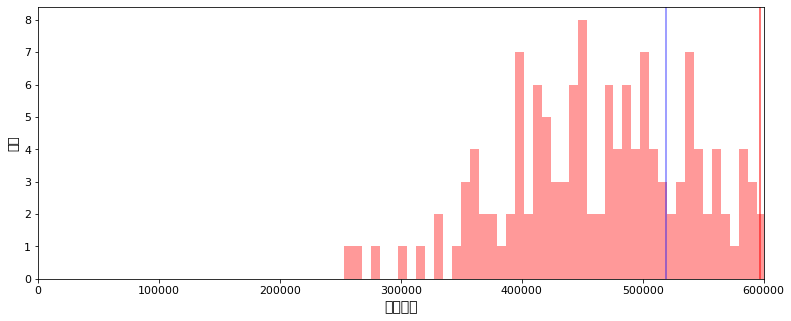

In [0]:
movie_combine = movie_combine.loc[movie_combine['评分人数'] != 'None',:]

fig,ax = plt.subplots(1,1,figsize = (13,5))
#plt.figure(figsize = (12,5))
sns.distplot(movie_combine['评分人数'].values,color = 'red',kde = False,bins = 200,ax = ax)
ax.axvline(movie_combine['评分人数'].mean(),color = 'red',alpha = 0.7)
ax.axvline(movie_combine['评分人数'].median(),color = 'blue',alpha = 0.5)
plt.xlim(0,600000)
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
ax.set_xlabel('评分人数', fontsize=14)
ax.set_ylabel('数量', fontsize=13)

Pandas中进行数据类型转换有三种基本方法：

1.使用astype()函数进行强制类型转换

```
data['状态'].astype('bool')
```

总结一下astype()函数有效的情形：

数据列中的每一个单位都能简单的解释为数字(2, 2.12等）

数据列中的每一个单位都是数值类型且向字符串object类型转换

如果数据中含有缺失值、特殊字符astype()函数可能失效。

2.自定义函数进行数据类型转换

```
data['2016'].apply(lambda x: x.replace('￥', '').replace(',', '')).astype('float')
```
或者
```
data['状态'] = np.where(data['状态'] == 'Y', True, False)
```

3.使用Pandas提供的函数如to_numeric()、to_datetime()

Pandas的astype()函数和复杂的自定函数之间有一个中间段，那就是Pandas的一些辅助函数。这些辅助函数对于某些特定数据类型的转换非常有用(如to_numeric()、to_datetime())。

所属组数据列中包含一个非数值，用astype()转换出现了错误，然而用to_numeric()函数处理就优雅很多。

```
pd.to_numeric(data['所属组'], errors='coerce').fillna(0)
```
```
pd.to_datetime(data[['day', 'month', 'year']])
```
在读取数据时就对数据类型进行转换，一步到位
```
data2 = pd.read_csv("data.csv",
                   converters={
                               '客户编号': str,
                               '2016': convert_currency,
                               '2017': convert_currency,
                               '增长率': convert_percent,
                               '所属组': lambda x: pd.to_numeric(x, errors='coerce'),
                               '状态': lambda x: np.where(x == "Y", True, False)
                              },
                   encoding='gbk')
```

In [0]:
print(movie_combine[movie_combine['上映时间'].isnull()])

Empty DataFrame
Columns: [Unnamed: 0_x, 主演, 海报, 导演, ID, 评分, 标记, 片名_x, 网址, Unnamed: 0_y, 片名_y, 上映时间, 电影类型, 片长, 地区, 评分人数, 评分分布, 简介, 热评, format_评分, 5星, 4星, 3星, 2星, 1星]
Index: []


In [0]:
movie_combine['上映时间']=pd.to_numeric(movie_combine['上映时间'], errors='coerce')
#pd.to_datetime(movie_combine['上映时间'], errors='ignore').fillna(0)
#pd.to_numeric(movie_combine['上映时间'], errors='coerce').fillna(0)

In [0]:
movie_combine = movie_combine.dropna(subset=['上映时间'])

In [0]:

movie_combine['上映时间'] = movie_combine['上映时间'].astype(int)

In [0]:
movie_combine['上映时间']

2      0
10     0
52     0
59     0
4      0
      ..
47     0
187    0
9      0
140    0
60     0
Name: 上映时间, Length: 200, dtype: int64

In [0]:
movie_combine['上映时间'] = movie_combine['上映时间'].convert_objects(convert_numeric=True)

In [0]:
from sklearn import preprocessing
def convert(data):
    number = preprocessing.LabelEncoder()
    data['column_name'] = number.fit_transform(data['上映时间'])
    data=data.fillna(-999)
    return data

In [0]:
movie_combine['上映时间']=pd.DataFrame(movie_combine['上映时间'],dtype=np.float)

In [0]:
movie_combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 2 to 60
Data columns (total 25 columns):
Unnamed: 0_x    200 non-null int64
主演              200 non-null object
海报              200 non-null object
导演              200 non-null object
ID              200 non-null int64
评分              200 non-null float64
标记              200 non-null int64
片名_x            200 non-null object
网址              200 non-null object
Unnamed: 0_y    200 non-null int64
片名_y            200 non-null object
上映时间            200 non-null int64
电影类型            200 non-null object
片长              200 non-null object
地区              200 non-null object
评分人数            200 non-null int64
评分分布            200 non-null object
简介              200 non-null object
热评              200 non-null object
format_评分       200 non-null object
5星              200 non-null float64
4星              200 non-null float64
3星              200 non-null float64
2星              200 non-null float64
1星              200 non-null floa

2.用中位数作为人数筛选机制

In [32]:
print('中位数:',movie_combine['评分人数'].median())
print('均值:',movie_combine['评分人数'].mean())
movie_f = movie_combine.loc[movie_combine['评分人数'] > movie_combine['评分人数'].median(),:]

中位数: 515841.0
均值: 591380.1428571428


3.上映时间和数量分布趋势

Text(0, 0.5, '数量')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 26102 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 38388 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 26144 missing from current font.
  font.set_te

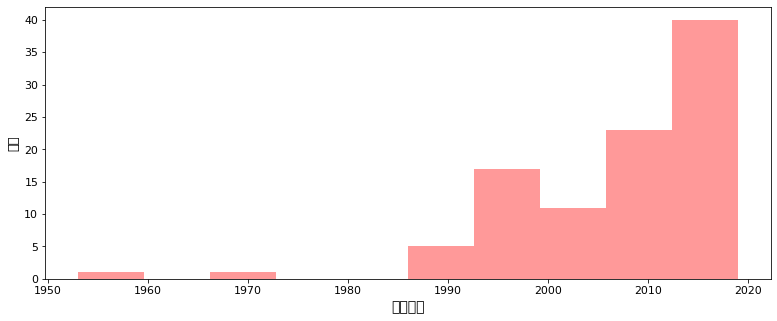

In [33]:
fig,ax = plt.subplots(1,1,figsize = (13,5))
sns.distplot(movie_f['上映时间'].values,color = 'red',kde = False,ax = ax)

plt.yticks(fontsize=11)
plt.xticks(fontsize=11)
ax.set_xlabel('上映时间', fontsize=14)
ax.set_ylabel('数量', fontsize=13)

4.不同年代电影数量

In [34]:
labels = []
for i in range(1910,2020,10):
    if i < 2000:
        century = '20世纪{}年代'.format(str(i)[2:])
    else:
        century = '21世纪{}年代'.format(str(i)[2:])
    labels.append(century)
    
century_f= pd.cut(movie_f['上映时间'].values,bins = list(range(1910,2030,10)),right = False,labels = labels).value_counts()
century_f

20世纪10年代     0
20世纪20年代     0
20世纪30年代     0
20世纪40年代     0
20世纪50年代     1
20世纪60年代     0
20世纪70年代     1
20世纪80年代     2
20世纪90年代    20
21世纪00年代    21
21世纪10年代    53
dtype: int64

5.年代打标

In [35]:
movie_f['年代'] = pd.cut(movie_f['上映时间'].values,bins = list(range(1910,2030,10)),right = False,labels = labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
#先按照年代，再按照评分排序
movie_f.sort_values(['年代','评分'],ascending = False)

,Unnamed: 0_x,主演,海报,导演,ID,评分,标记,片名_x,网址,Unnamed: 0_y,片名_y,上映时间,电影类型,片长,地区,评分人数,评分分布,简介,热评,年代
5,0,"['莱昂纳多·迪卡普里奥', '约瑟夫·高登-莱维特', '艾伦·佩吉', '汤姆·哈迪',...",https://img3.doubanio.com/view/photo/s_ratio_p...,['克里斯托弗·诺兰'],3541415,9.3,45,盗梦空间,https://movie.douban.com/subject/3541415/,0,盗梦空间 Inception,2010,"['剧情', '科幻', '悬疑', '冒险']",148,美国 / 英国,1308870,"{'力荐': '70.5%', '推荐': '25.2%', '还行': '3.9%', '...",道姆·柯布（莱昂纳多·迪卡普里奥 Leonardo DiCaprio 饰）与同事阿瑟（约瑟夫...,大概广电局也不知道该从哪里剪,21世纪10年代
25,0,"['马修·麦康纳', '安妮·海瑟薇', '杰西卡·查斯坦', '卡西·阿弗莱克', '迈克...",https://img3.doubanio.com/view/photo/s_ratio_p...,['克里斯托弗·诺兰'],1889243,9.3,45,星际穿越,https://movie.douban.com/subject/1889243/,0,星际穿越 Interstellar,2014,"['剧情', '科幻', '冒险']",169,美国 / 英国 / 加拿大 / 冰岛,952523,"{'力荐': '70.4%', '推荐': '24.0%', '还行': '4.8%', '...",近未来的地球黄沙遍野，小麦、秋葵等基础农作物相继因枯萎病灭绝，人类不再像从前那样仰望星空，放...,太壮阔了，无以言表！40'渐入佳境，80'叹为观止，120'泪流满面，160'恍如隔世…不曾...,21世纪10年代
117,0,"['孔侑', '郑有美', '金志映', '金贤秀', '郑仁絮']",https://img3.doubanio.com/view/photo/s_ratio_p...,['黄东赫'],5912992,9.3,45,熔炉,https://movie.douban.com/subject/5912992/,0,熔炉 도가니,2011,['剧情'],125,韩国,563068,"{'力荐': '69.8%', '推荐': '26.1%', '还行': '3.7%', '...",来自首尔的哑语美术老师仁浩（孔宥 饰）来到雾津，应聘慈爱聋哑人学校。天降大雾，他意外撞车，维...,人口大国什么时候能拍出这样的片子，这样在嘲笑棒子的时候才有点底气。,21世纪10年代
85,0,"['弗朗索瓦·克鲁塞', '奥玛·希', '安娜·勒尼', '奥德雷·弗勒罗', '托马·索...",https://img3.doubanio.com/view/photo/s_ratio_p...,"['奥利维埃·纳卡什', '埃里克·托莱达诺']",6786002,9.2,45,触不可及,https://movie.douban.com/subject/6786002/,0,触不可及 Intouchables,2011,"['剧情', '喜剧']",112,法国,629146,"{'力荐': '66.6%', '推荐': '28.5%', '还行': '4.5%', '...",因为一次跳伞事故，白人富翁菲利普Philippe（弗朗索瓦·克鲁塞 François Clu...,我想每个人都至少有这么一个挚友，你和他/她在人生的拐点遇到，惊叹于彼此的不同或者相似，有过不...,21世纪10年代
27,0,"['安东尼·冈萨雷斯', '盖尔·加西亚·贝纳尔', '本杰明·布拉特', '阿兰娜·乌巴赫...",https://img3.doubanio.com/view/photo/s_ratio_p...,"['李·昂克里奇', '阿德里安·莫利纳']",20495023,9.1,45,寻梦环游记,https://movie.douban.com/subject/20495023/,0,寻梦环游记 Coco,2017,"['喜剧', '动画', '音乐', '奇幻']",105,美国,912946,"{'力荐': '61.0%', '推荐': '31.5%', '还行': '6.9%', '...",热爱音乐的米格尔（安东尼·冈萨雷兹 Anthony Gonzalez 配音）不幸地出生在一个...,供奉的遗像是牵引家人回家的通道，驻留的记忆是保持亡灵存续的神力，热闹的音乐是唤醒思念启封的药...,21世纪10年代
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,0,"['周星驰', '巩俐', '陈百祥', '郑佩佩', '朱咪咪']",https://img3.doubanio.com/view/photo/s_ratio_p...,['李力持'],1306249,8.6,45,唐伯虎点秋香,https://movie.douban.com/subject/1306249/,0,唐伯虎点秋香 唐伯虎點秋香,1993,"['喜剧', '爱情', '古装']",102,中国香港,614299,"{'力荐': '43.2%', '推荐': '43.7%', '还行': '12.4%', ...",唐伯虎（周星驰 饰）身为江南四大才子之首，却有道不尽的心酸。宁王想唐伯虎帮忙图谋作反，唐伯虎...,可以忽略秋香……,20世纪90年代
31,0,"['日高法子', '坂本千夏', '糸井重里', '岛本须美', '北林谷荣']",https://img3.doubanio.com/view/photo/s_ratio_p...,['宫崎骏'],1291560,9.2,45,龙猫,https://movie.douban.com/subject/1291560/,0,龙猫 となりのトトロ,1988,"['动画', '奇幻', '冒险']",86,日本,806169,"{'力荐': '64.6%', '推荐': '29.2%', '还行': '5.8%', '...",小月的母亲生病住院了，父亲带着她与四岁的妹妹小梅到乡间的居住。她们对那里的环境都感到十分新奇...,日本的动画总是能触碰心灵和温情,20世纪80年代
83,0,"['田中真弓', '横泽启子', '初井言荣', '寺田农', '常田富士男']",https://img3.doubanio.com/view/photo/s_ratio_p...,['宫崎骏'],1291583,9.1,45,天空之城,https://movie.douban.com/subject/1291583/,0,天空之城 天空の城ラピュタ,1986,"['动画', '奇幻', '冒险']",125,日本,545648,"{'力荐': '61.8%', '推荐': '31.8%', '还行': '6.0%', '...",古老帝国拉比达是一座漂浮在空中的巨大的机器岛，传说那里已经无人居住，蕴藏着巨大的财富。因此，...,None,20世纪80年代
89,0,"['马龙·白兰度', '阿尔·帕西诺', '詹姆斯·肯恩', '理查德·卡斯特尔诺', '罗...",https://img3.doubanio.com/view/photo/s_ratio_p...,['弗朗西斯·福特·科波拉'],1291841,9.3,45,教父,https://movie.douban.com/subject/1291841/,0,教父 The Godfather,1972,"['剧情', '犯罪']",175,美国,590846,"{'力荐': '70.2%', '推荐': '24.2%', '还行': '5.0%', '...",40年代的美国，“教父”维托·柯里昂（马龙·白兰度 饰）是黑手党柯里昂家族的首领，带领家族从...,None,20世纪70年代


6.灵活筛选

In [0]:
final_rank = pd.DataFrame()
for century,count in zip(century_f.index,century_f.values):
    f1 = movie_f.loc[movie_f['年代'] == century,:]
    if count < 1000:
        return_num = int(count * 0.1)
    f2 = f1.iloc[:return_num,:]
    final_rank = pd.concat([final_rank,f2])

In [38]:
final_rank.head(1)

,Unnamed: 0_x,主演,海报,导演,ID,评分,标记,片名_x,网址,Unnamed: 0_y,片名_y,上映时间,电影类型,片长,地区,评分人数,评分分布,简介,热评,年代
1,0,"['让·雷诺', '娜塔莉·波特曼', '加里·奥德曼', '丹尼·爱罗', '彼得·阿佩尔']",https://img3.doubanio.com/view/photo/s_ratio_p...,['吕克·贝松'],1295644,9.4,45,这个杀手不太冷,https://movie.douban.com/subject/1295644/,0,这个杀手不太冷 Léon,1994,"['剧情', '动作', '犯罪']",110分钟(剧场版) / 133分钟(国际版)\n 又名: 杀手莱昂 / 终极...,法国,1537547,"{'力荐': '74.1%', '推荐': '22.5%', '还行': '3.1%', '...",里昂（让·雷诺饰）是名孤独的职业杀手，受人雇佣。一天，邻居家小姑娘马蒂尔达（纳塔丽·波特曼饰...,萝莉有颗御姐心，正太有个大叔身——邪恶又天真、残酷又温柔，多完美~,20世纪90年代


In [0]:
#final_rank.to_excel('最终电影排名结果.xlsx')

7.词云绘制

In [0]:
from pyecharts import WordCloud

myWordCloud = WordCloud("绘制词云",width=1000, height=200)

#词云图暂时剔除掉包含篇、版相对小众的动漫
final_rank_f = final_rank.loc[(final_rank['片名_x'].str.find('篇') == -1) & 
                              (final_rank['片名_x'].str.find('版') == -1) &
                              (final_rank['片名_x'].str.find('界') == -1),:]

In [0]:
for i in final_rank_f['年代'].unique():
    name = final_rank_f.loc[final_rank_f['年代'] == i,'片名_x'].values[:5]
    value = final_rank_f.loc[final_rank_f['年代'] == i,'评分'].values[:5]
    names = []
    for n,v in zip(name,value):
        n = n + ' ' + str(v)
        names.append(n)
    myWordCloud = WordCloud(i,width=1000, height=500)
    myWordCloud.add("",attr = names,value = value,word_size_range=[30,40],shape = 'cardioid')
    myWordCloud.render(i + '.html')